In [1]:
import os
import json
import random
import numpy as np
import pprint as pp
import soundfile as sf
from scipy.io import wavfile as wave
from python_speech_features import mfcc
from numpy.lib.stride_tricks import as_strided

import matplotlib.pyplot as plt
%matplotlib inline

from utils import *

In [2]:
def FeatureMFCC(wave_path, dim=13):
    with sf.SoundFile(wave_path) as sound_file:
        audio = sound_file.read(dtype='float32')  # 音频数据
        sample_rate = sound_file.samplerate       # 16000 音频采样率

        mfcc_result = mfcc(audio, sample_rate, numcep=dim)
        return mfcc_result


def FeatureSPEC(wave_path, max_freq=8000, step=10, window=20):
    eps = 1e-14
    with sf.SoundFile(wave_path) as sound_file:
        audio = sound_file.read(dtype='float32')  # 音频数据
        sample_rate = sound_file.samplerate       # 16000 音频采样率

        hop_length = int(0.001 * step * sample_rate)  # 160
        fft_length = int(0.001 * window * sample_rate)  # 320

        window = np.hanning(fft_length)[:, None]
        window_norm = np.sum(window**2)

        # scale为缩放比例
        scale = window_norm * sample_rate

        trunc = (len(audio) - fft_length) % hop_length
        x = audio[:len(audio) - trunc]

        # "stride trick" reshape to include overlap
        nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
        nstrides = (x.strides[0], x.strides[0] * hop_length)
        x = as_strided(x, shape=nshape, strides=nstrides)

        # wondow步长检查
        assert np.all(x[:, 1] == audio[hop_length:(hop_length + fft_length)])

        # broadcast window, 计算傅里叶变换FFT
        x = np.fft.rfft(x * window, axis=0)
        x = np.absolute(x)**2

        # scale, 2.0 for everything except dc and fft_len/2
        x[1:-1, :] *= (2.0 / scale)
        x[(0, -1), :] /= scale

        freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

        ind = np.where(freqs <= max_freq)[0][-1] + 1
        return np.transpose(np.log(x[:ind, :] + eps))


In [3]:
def text2seq(text):
    """convert text sequence"""
    return [char_map['_'] if c == ' ' else char_map[c] for c in text]

In [4]:
class AudioHandler():
    def __init__(self, batch_size=20, feature_type='spectrogram'):
        self.step = 10
        self.window = 20
        self.max_freq = 8000
        self.eps = 1e-14
        self.train_index = 0
        self.valid_index = 0
        self.train_len = 0
        self.valid_len = 0
        self.mfcc_dim = 13
        self.spec_dim = int(0.001 * self.window * self.max_freq) + 1
        self.batch_size = batch_size
        self.feature_type = feature_type
        if feature_type == 'spectrogram':
            self.feature_mean = np.zeros((self.spec_dim,))
            self.feature_std = np.zeros((self.spec_dim,))
        elif feature_type == 'mfcc':
            self.feature_mean = np.zeros((self.mfcc_dim,))
            self.feature_std = np.zeros((self.mfcc_dim,))

    def load_train_data(self, file=None):
        """读取训练集"""
        paths, times, texts = self._load_data_from_file(file)
        if len(paths) == len(times) and len(times) == len(texts):
            self.train_len = len(paths)
        else:
            raise Exception("Train data len is not same.")

        self.train_paths = paths
        self.train_times = times
        self.train_texts = texts
        self.fit_train()

    def load_test_data(self, file=None):
        """读取测试集"""
        paths, times, texts = self._load_data_from_file(file)
        if len(paths) == len(times) and len(times) == len(texts):
            self.valid_len = len(paths)
        else:
            raise Exception("Valid data len is not same.")

        self.valid_paths = paths
        self.valid_times = times
        self.valid_texts = texts

    def _load_data_from_file(self, file):
        if not os.path.isfile(file):
            raise Exception("Input file error.")

        paths = []
        times = []
        texts = []
        with open(file) as json_file:
            for i, data in enumerate(json_file):
                spec = json.loads(data)
                paths.append(spec['path'])
                times.append(spec['time'])
                texts.append(spec['text'])

        return paths, times, texts

    def fit_train(self, n_samples=10):
        """
        before fit the training data we need to calculate the feature mean
        and feature std for normalization.
        """
        samples = random.sample(self.train_paths, n_samples)
        if self.feature_type == 'spectrogram':
            feats = [self.featurize_normal(s) for s in samples]
        elif self.feature_type == 'mfcc':
            feats = [self.featurize_mfcc(s) for s in samples]
        feats = np.vstack(feats)
        self.feature_mean = np.mean(feats, axis=0)
        self.feature_std = np.std(feats, axis=0)

    def get_batchs(self, batch_name):
        """
        Get a batch of train, validation.
        """
        if batch_name == 'train':
            index = self.train_index
            paths = self.train_paths
            texts = self.train_texts
        elif batch_name == 'valid':
            index = self.valid_index
            paths = self.valid_paths
            texts = self.valid_texts
        else:
            raise Exception("Invalid batch name.")

        if self.feature_type == 'spectrogram':
            dim = self.spec_dim
            feats = [self.featurize_normal(
                p) for p in paths[index:index + self.batch_size]]
        elif self.feature_type == 'mfcc':
            dim = self.mfcc_dim
            feats = [self.featurize_mfcc(
                p) for p in paths[index:index + self.batch_size]]
        norfeats = [self.normalize(f) for f in feats]

        # calculate size for input data and output data.
        # max_len in bacth feature, example: (2939,13) or (2939, 161)
        # max_textlen in batch text, example: (65)
        max_len = max([norfeats[i].shape[0]
                       for i in range(0, self.batch_size)])
        max_textlen = max([len(texts[index + i])
                           for i in range(0, self.batch_size)])

        # init necessary arrays
        input_data = np.zeros([self.batch_size, max_len, dim])      # (20, 2939, 13)
        output_data = np.ones([self.batch_size, max_textlen]) * 28  # (20，65)
        input_len = np.zeros([self.batch_size, 1])                  # (20, 1)
        output_len = np.zeros([self.batch_size, 1])                 # (20, 1)

        for i, feat in enumerate(norfeats):
            # calculate input data and input lenght
            input_len[i] = feat.shape[0]
            input_data[i, :feat.shape[0], :] = feat

            # calculate output data and output length
            label = np.array(text2seq(texts[index + i]))
            output_data[i, :len(label)] = label
            output_len[i] = len(label)

        # for return
        inputs = {
            'the_input': input_data,
            'the_labels': output_data,
            'input_length': input_len,
            'label_length': output_len,
        }
        outputs = {
            'ctc': np.zeros([self.batch_size])  # (20,)
        }
        # pp.pprint(inputs)
        # pp.pprint(outputs)
        return (inputs, outputs)

    def next_train(self):
        """
        get the batch of training data.
        """
        while True:
            batchs_result = self.get_batchs('train')
            self.train_index += self.batch_size
            if self.train_index >= len(self.train_paths) - self.batch_size:
                self.train_index = 0
                self.__shuffle_data('train')
            yield batchs_result

    def next_val(self):
        """
        Get the batch of validation data.
        """
        while True:
            batchs_result = self.get_batchs('valid')
            self.valid_index += self.batch_size
            if self.valid_index >= len(self.train_paths) - self.batch_size:
                self.valid_index = 0
                self.__shuffle_data('valid')
            yield batchs_result
            
    def __shuffle_data(self, shuffle_name):
        """
        Shuffle the training or validation data.
        """
        if shuffle_name == 'train':
            per = np.random.permutation(self.train_len)
            paths = [self.train_paths[i] for i in p]
            times = [self.train_paths[i] for i in p]
            texts = [self.train_texts[i] for i in p]
            self.train_paths = paths
            self.train_times = times
            self.train_texts = texts
        elif shuffle_name == 'valid':
            per = np.random.permutation(self.valid_index)
            paths = [self.valid_paths[i] for i in p]
            times = [self.valid_times[i] for i in p]
            texts = [self.valid_texts[i] for i in p]
            self.valid_paths = paths
            self.valid_times = times
            self.valid_texts = texts
        else:
            raise Exception("Invalid shuffle data typename.")

    def normalize(self, feature):
        """
        对特征进行归一化处理
        """
        return (feature - self.feature_mean) / (self.feature_std + self.eps)

    def featurize_mfcc(self, wave_path):
        """
        Given audio wave path, calculate the corrsponding MFCC feature.
        """
        return FeatureMFCC(wave_path)

    def featurize_normal(self, wave_path):
        """
        Given audio wave path, calculate the corrsponding Spectrogram feature.
        """
        return FeatureSPEC(wave_path,
                           max_freq=self.max_freq,
                           step=self.step,
                           window=self.window)


In [10]:
loading_path = "/Users/chenzomi/Documents/DeepLearnInAction/code/data/LibriSpeech/"
train_path = os.path.join(loading_path, "train_corpus.json")
              
# audio_gen = AudioHandler(feature_type='mfcc', batch_size=20)
audio_gen = AudioHandler()
audio_gen.load_train_data(train_path)

index = 666
raw_audio = audio_gen.train_paths[index]
raw_text = audio_gen.train_texts[index]
print("testing data:\n[{}]".format(raw_text))

spect_feature = audio_gen.featurize_normal(raw_audio)
mfcc_feature = audio_gen.featurize_mfcc(raw_audio)

testing data:
[a shop girl was the destiny prefigured for the newcomer]


(115648,)
array([  109,   106,    95,    75,    75,    50,    -1,   -33,   -68,
        -113,  -144,  -174,  -199,  -198,  -190,  -194,  -212,  -249,
        -286,  -306,  -314,  -308,  -301,  -313,  -322,  -291,  -238,
        -201,  -213,  -268,  -278,  -200,  -162,  -267,  -374,  -339,
        -242,  -212,  -263,  -272,  -153,   -58,  -114,  -179,  -160,
        -131,  -102,  -100,  -153,  -127,   -36,   -16,   -14,   -34,
        -105,   -49,    38,   -47,  -188,  -569, -1124,  -572,  1318,
        2181,   565, -1396,  -997,   977,  1250,  -801, -1908,  -344,
        1436,  1307,   321,   196,   945,  1139,   -78, -1375, -1065,
         216,   696,   149,  -192,   377,  1092,   906,   -19,  -645,
        -491,  -227,  -622, -1037,  -291,   995,  1104,   -70,  -965,
        -487,   609,   572,  -717, -1325,  -375,   633,   370,  -481,
        -412,   684,  1121,  -100, -1471, -1111,   395,   924,   -48,
        -845,  -279,   668,   576,  -422, -1075,  -678,   115,   370,
         2

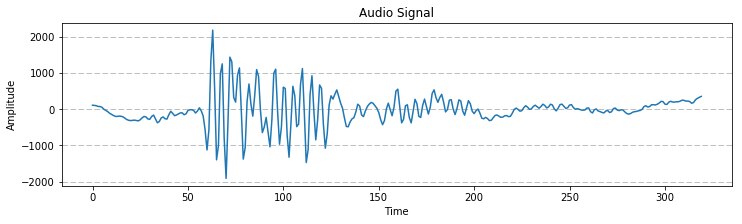

In [7]:
def plot_raw_audio(raw_feature):
    pp.pprint(raw_feature[1].shape)
    pp.pprint(raw_feature[1][39900:40220])
    
    fig = plt.figure(figsize=(12, 3))
    ax = fig.add_subplot(111)
    ax.plot(raw_feature[1][39900:40220])
    plt.title("Audio Signal")
    plt.xlabel('Time')
    plt.ylabel("Amplitude")
    plt.grid(True, linestyle='dashed', axis='y')
    plt.show()

hello_path = "/Users/chenzomi/Documents/DeepLearnInAction/code/chapter8/Hello.wav"
plot_raw_audio(wave.read(hello_path))

(53760,)


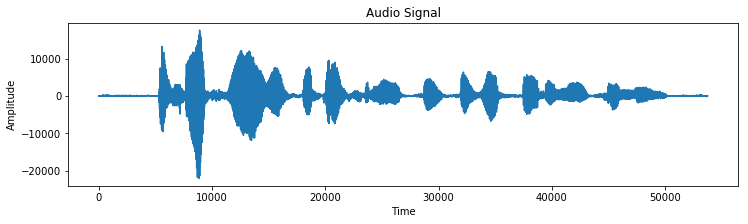

In [8]:
def plot_raw_audio(raw_feature):
    pp.pprint(raw_feature[1].shape)

    fig = plt.figure(figsize=(12, 3))
    ax = fig.add_subplot(111)
    ax.plot(raw_feature[1])
    plt.title("Audio Signal")
    plt.xlabel('Time')
    plt.ylabel("Amplitude")
    plt.show()
    
plot_raw_audio(wave.read(raw_audio))

(335, 161)


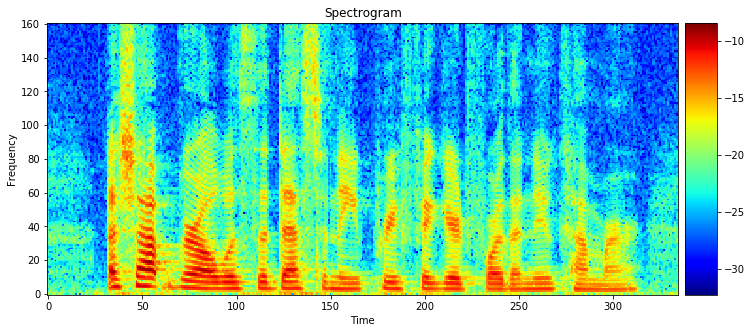

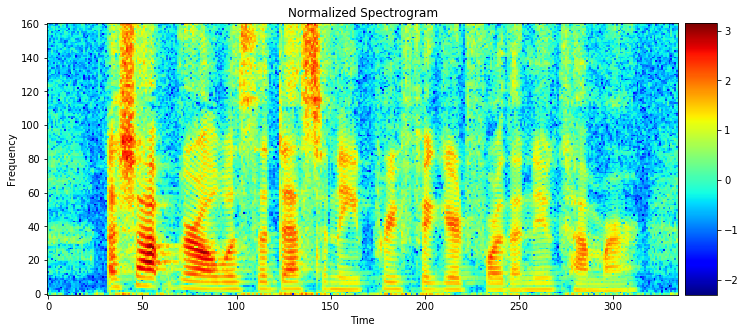

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_spect_feature(spect_feature, name=None):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(spect_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title(name)
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.gca().invert_yaxis()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    plt.show()
    
pp.pprint(spect_feature.shape)
tr_spec_feature = np.transpose(spect_feature, (1, 0))
norspec_feature = audio_gen.normalize(spect_feature)
tr_norspec_feature = np.transpose(norspec_feature, (1, 0))

plot_spect_feature(tr_spec_feature, "Spectrogram")
plot_spect_feature(tr_norspec_feature, "Normalized Spectrogram")

(335, 161)


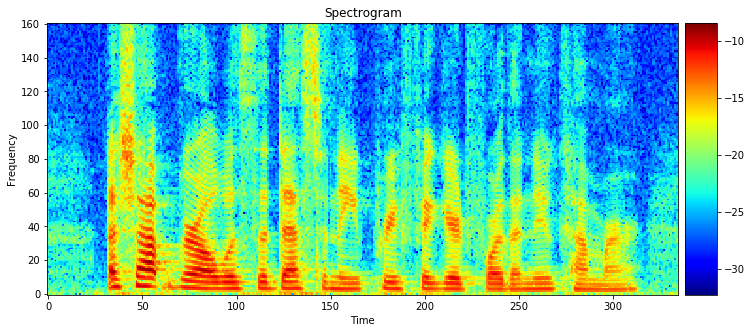

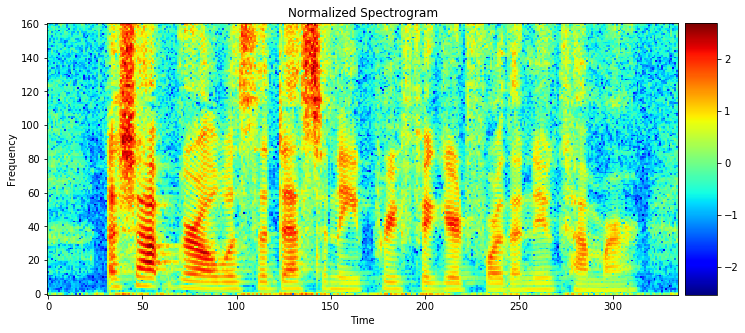

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_spect_feature(spect_feature, name=None):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(spect_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title(name)
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    plt.gca().invert_yaxis()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(im, cax=cax)
    plt.show()
    
pp.pprint(spect_feature.shape)
tr_spec_feature = np.transpose(spect_feature, (1, 0))
norspec_feature = audio_gen.normalize(spect_feature)
tr_norspec_feature = np.transpose(norspec_feature, (1, 0))

plot_spect_feature(tr_spec_feature, "Spectrogram")
plot_spect_feature(tr_norspec_feature, "Normalized Spectrogram")

(335, 13)
(335, 13)


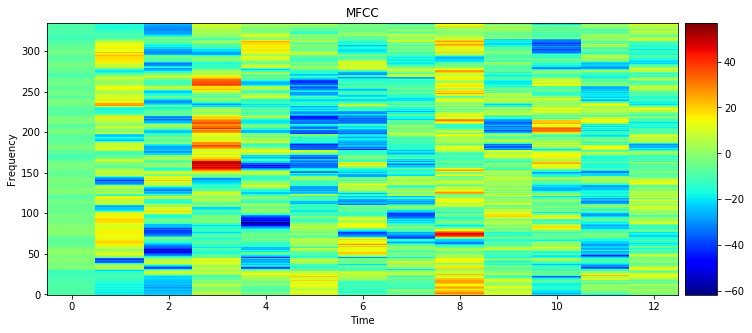

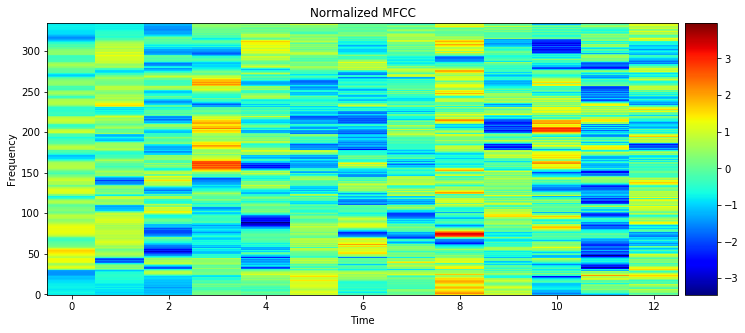

In [64]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_mfcc_feature(mfcc_feature, name):
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    im = ax.imshow(mfcc_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title(name)
    plt.ylabel('Frequency')
    plt.xlabel('Time')
    divider = make_axes_locatable(ax)
    cax = divider.append("right", size= "5%", pad = 0.1)
    plt.colorbar(im, cax = cax)
    ax.set_xticks(np.arange(0, 13, 2), minor = False);
    plt.show()
    
pp.pprint(mfcc_feature.shape)
tr_normfcc_feature = audio_gen.normalize(mfcc_feature)
pp.pprint(tr_normfcc_feature.shape)

plot_spect_feature(mfcc_feature, "MFCC")
plot_spect_feature(tr_normfcc_feature, "Normalized MFCC")

In [97]:
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, TimeDistributed, BatchNormalization, Bidirectional
from keras.layers import GRU, Input, Dense, Activation

In [98]:
def bidirectional_GRU_model(input_dim, units, output_dim = 28, dropout_rate = 0.5, number_layers=2):
    """
    Build a deep bidirectional GRU model for austical sepeech
    """
    
    inputs = Input(shape=(None, input_dim), name="the_input")
    
    if number_layers == 1:
        cell = GRU(units, activation='relu', return_sequences=True, dropout=dropout_rate)
        bidir_rnn = Bidirectional(cell, merge_mode='concat', name="bid_GRU")(inputs)
        layer = BatchNormalization(name='BN')(bidir_rnn)
    else:
        cell = GRU(units, activation='relu', return_sequences=True, dropout=dropout_rate)
        bidir_rnn = Bidirectional(cell, merge_mode='concat', name="bid_GRU")(inputs)
        layer = BatchNormalization(name='BN')(bidir_rnn)
        
        for i in range(number_layers - 2):
            bidir_rnn = Bidirectional(cell, merge_mode='concat', name="bid_GRU_{}".format(i+2))(layer)
            layer = BatchNormalization(name='BN_{}'.format(i+2))(bidir_rnn)
            
        bidir_rnn = Bidirectional(cell, merge_mode='concat', name="bid_GRU_final")(layer)
        layer = BatchNormalization(name='BN_final')(bidir_rnn)
    
    x = TimeDistributed(Dense(output_dim), name="distribute")(layer)
    x = Activation('softmax', name="output")(x)
    
    model = Model(inputs=inputs, outputs=x)
    return model
    
rnn_model = bidirectional_GRU_model(input_dim = 13, units=200)
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
bid_GRU (Bidirectional)      (None, None, 400)         617400    
_________________________________________________________________
BN (BatchNormalization)      (None, None, 400)         1600      
_________________________________________________________________
bid_GRU_final (Bidirectional (None, None, 400)         849600    
_________________________________________________________________
BN_final (BatchNormalization (None, None, 400)         1600      
_________________________________________________________________
distribute (TimeDistributed) (None, None, 28)          11228     
_________________________________________________________________
output (Activation)          (None, None, 28)          0         
Total para

In [99]:
rnn_model.output_shape
rnn_model.output

<tf.Tensor 'output_3/truediv:0' shape=(?, ?, 28) dtype=float32>

In [100]:
def CTC_lambda(args):
    """
    ctc_batch_cost(y_true, y_pred, input_length, label_length)
    """
    y_pred, y_true, input_length, label_length = args
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

def CTC_loss(rnn_model):
    labels = Input(shape=(None,), dtype='float32', name='the_labels')
    input_length = Input(shape=(1,), dtype='int64', name='input_length')
    label_length = Input(shape=(1,), dtype='int64', name='label_length')

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(CTC_lambda, output_shape=(1,), name='ctc')(
        [rnn_model.output, labels, input_length, label_length])
    
    model = Model(inputs=[rnn_model.input, labels, input_length, label_length], outputs=loss_out)
    return model

In [ ]:
loading_path = "/Users/chenzomi/Documents/DeepLearnInAction/code/data/LibriSpeech/"
train_path = os.path.join(loading_path, "train_corpus.json")
test_path = os.path.join(loading_path, "test_corpus.json")


# 加载把训练集和验证集（测试集）
audio_gen = AudioHandler(feature_type='mfcc', batch_size=20)
audio_gen.load_train_data(train_path)
audio_gen.load_test_data(test_path)


# 计算测试集epoch内的样本数
train_steps = audio_gen.train_len // batch_size
valid_steps = audio_gen.valid_len // batch_size

print(audio_gen.train_len, train_steps)
print(audio_gen.valid_len, valid_steps)


# 添加 CTC 损失函数
acoustic_model = CTC_loss(rnn_model)
# print(acoustic_model.summary())

sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
acoustic_model.compile(loss={'ctc':lambda y_ture, y_pred:rnn_model.output},
                       optimizer = sgd)

if not os.path.exists('rnn_checkpoints'):
    os.mkdir('rnn_checkpoints')
    
checkpoint = ModelCheckpoint(monitor='val_acc', 
                             filepath = 'rnn_checkpoints/model_{epoch:02d}_{val_acc:.3f}.h5',
                             save_best_only = True)


# model.fit(x_train, y_train,
#          batch_size = 128,
#          epochs = 30,
#          verbose = 1,
#          validation_data = (x_test, y_test),
#          callbacks = [checkpoint])
audio_gen.batch_size = batch_size
acoustic_model.fit_generator(generator=audio_gen.next_train(),
                    steps_per_epoch=train_steps,
                    epochs=100,
                    validation_data=audio_gen.next_val(),
                    validation_steps=valid_steps,
                    callbacks=[checkpoint],
                    verbose=1)

2703 108
2620 104
Epoch 1/100
